In [1]:
from food.tools import *
from food.paths import *
from food.psql import *
import numpy as np
import torch
from torch.nn import CosineSimilarity
import requests
from food.qdrant import *
cos = CosineSimilarity(dim=1, eps=1e-08)
import pandas as pd

In [2]:
def search_image(url=None,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    image_clip = torch.Tensor(image_clip)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return image_clip,df.reset_index()

series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [3]:
collection_name = 'food'
table = 'foods'
foods = read_sql(table)
foods = foods.set_index('id')

In [79]:
text_to_vector = lambda text: torch.Tensor(requests.post(f'https://guru.skynet.center/text2vector/?text={text}').json())

In [134]:
types = [50,100,150,200,250,300,350,400]
types_ = [text_to_vector(f'picture of {t}  grams of food') for t in types ]

types_ = torch.cat(types_).reshape(len(types),768)

In [135]:
drop_vector =      lambda clip, i: torch.cat([clip[0:i], clip[i+1:]])

def multiply_vector(clip,i,n=1):
    duplicated = torch.cat([clip[i].reshape(1,768) for _ in range(n)])
    return torch.cat([clip, duplicated.reshape(n,768)])

In [160]:
url = 'https://image.shutterstock.com/image-photo/steak-vegetables-tomatoes-ketchup-red-600w-1114611659.jpg'
image_clip,df = search_image(url,head=100)

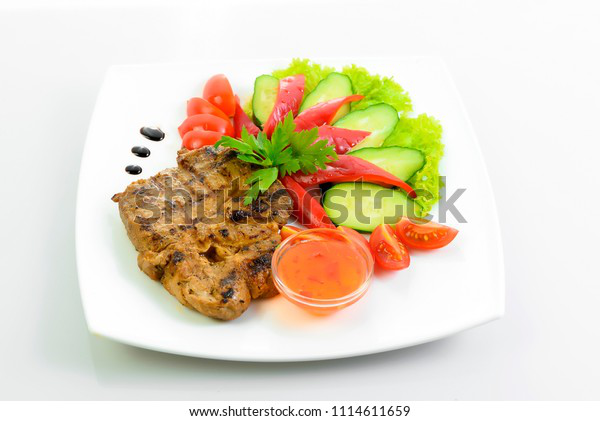

In [161]:
read_image_from_url(url)

In [162]:
values = cos(image_clip.reshape(1,768), types_.reshape(len(types),768))

In [163]:
pd.DataFrame({'types':types,'values':values}).sort_values('values',ascending = False)

,types,values
0,50,0.261789
3,200,0.260965
2,150,0.259438
6,350,0.256691
1,100,0.255910
4,250,0.255820
5,300,0.251139
7,400,0.250651


In [129]:
r

tensor([0.2225, 0.2239, 0.2234, 0.2342, 0.2303, 0.2309, 0.2274, 0.2302, 0.2258,
        0.2357])

In [521]:
selected = df.copy()

In [522]:
selected['altered_description'] = ('the food is ' +
                                  selected['category'] + ' .'
                                  ' It has a little bit of  ' +
                                  selected['description'].str.split(',').apply(lambda l:' '.join(list(reversed(l))))
                                #   ' which blongs to ' 
                                  # + selected['category']
                                  ).str.lower().str.replace(':','')
                                   #selected['category']#+' '+selected['description'].str.replace(',','') I am going to eat some )

In [523]:
clip = []
for i in selected.index:
    text = selected.loc[i,'altered_description']
    clip.append(requests.post(f'https://guru.skynet.center/text2vector/?text={text}').json())
selected['clip'] = clip

In [524]:
selected = selected.reset_index(drop=True)
clip = series2tensor(selected['clip'])
initscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))


In [529]:
selected = selected.reset_index(drop=True)
for i in reversed(selected.index):
    clip = series2tensor(selected['clip'])
    dropped = drop_vector(clip,i)
    testscore = cos(image_clip.reshape(1,768), dropped.mean(0).reshape(1,768))

    if testscore > initscore-0.001: 
        r = selected.loc[i,'altered_description']
        selected = selected.drop(i)
        initscore = testscore

    else:
        extra = multiply_vector(clip,i,1)
        testscore = cos(image_clip.reshape(1,768), extra.mean(0).reshape(1,768))
        if testscore > initscore: 
            selected = selected.append(selected.loc[i])
            initscore = testscore

    

print(initscore)
count = selected.groupby('altered_description')['clip'].count().sort_index()
r = selected.drop_duplicates('altered_description').set_index("altered_description").sort_index()
r['count'] = count
r = r.sort_values('count',ascending = False)
r['cumcount'] = r['count'].cumsum()/r['count'].sum()
r.drop(columns = ['clip'])

tensor([0.2363], dtype=torch.float64)


,id,description,category,energy,protein,carb,fat,score,count,cumcount
altered_description,,,,,,,,,,
the food is baby food fruit . it has a little bit of junior baby food pears,1102808,"Pears, baby food, junior",Baby food: fruit,44.0,0.3,11.6,0.1,0.255862,1,1.0


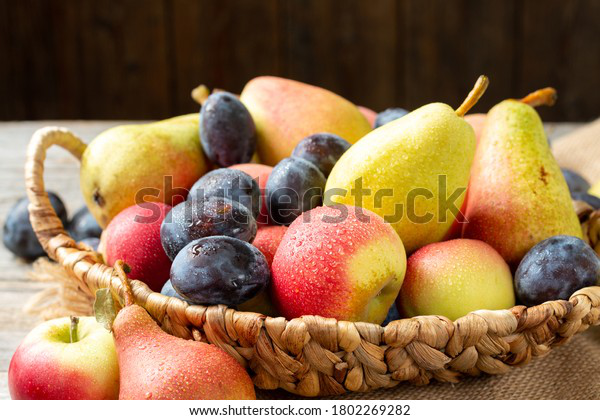

In [466]:
read_image_from_url(url)

In [43]:
selected = selected.reset_index(drop=True)

In [44]:
clip = series2tensor(selected['clip'])

In [45]:
dropped = drop_vector(clip,0)

In [48]:
initscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))

In [49]:
initscore

tensor([0.2959], dtype=torch.float64)

In [46]:
testscore = cos(image_clip.reshape(1,768), dropped.mean(0).reshape(1,768))

In [47]:
testscore

tensor([0.2958], dtype=torch.float64)

In [10]:
clip

tensor([[-0.0134,  0.0236, -0.0090,  ..., -0.0196, -0.0426, -0.0196],
        [-0.0095,  0.0263, -0.0034,  ..., -0.0126, -0.0527, -0.0198],
        [-0.0159,  0.0291,  0.0129,  ..., -0.0046, -0.0566, -0.0300],
        ...,
        [-0.0023,  0.0206, -0.0077,  ...,  0.0501,  0.0134,  0.0433],
        [ 0.0071,  0.0115,  0.0154,  ...,  0.0072, -0.0569,  0.0140],
        [ 0.0154, -0.0088,  0.0130,  ..., -0.0017, -0.0147, -0.0298]],
       dtype=torch.float64)

In [72]:
selected['altered_description'] = 'I am going to eat some ' +selected['description'].str.split(',').apply(lambda l:' '.join(list(reversed(l)))) #selected['category']#+' '+selected['description'].str.replace(',','') I am going to eat some 

In [73]:
clip = []
for i in selected.index:
    text = selected.loc[i,'altered_description']
    clip.append(requests.post(f'https://guru.skynet.center/text2vector/?text={text}').json())
selected['clip'] = clip

In [74]:
selected = selected.reset_index(drop=True)
clip = series2tensor(selected['clip'])
initscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))

In [82]:

selected = selected.reset_index(drop=True)
for i in reversed(selected.index):
    clip = series2tensor(selected['clip'])
    T = torch.cat([clip, clip[i].reshape(1,768)])
    testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
    if testscore > initscore: 
        selected = selected.append(selected.loc[i])
        
        # print(f"added {selected.loc[i,'description']}")
        initscore = testscore
    else:

        T = torch.cat([clip[0:i], clip[i+1:]])
        testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
        if testscore > initscore: 
            r = selected.loc[i,'altered_description']
            selected = selected.drop(i)
            initscore = testscore
            # print(f"removed {r}")




print(initscore)
count = selected.groupby('altered_description')['clip'].count().sort_index()
r = selected.drop_duplicates('altered_description').set_index("altered_description").sort_index()
r['count'] = count
r = r.sort_values('count',ascending = False)
r['cumcount'] = r['count'].cumsum()/r['count'].sum()
r

tensor([0.2570], dtype=torch.float64)


,id,description,clip,score,count,cumcount
altered_description,,,,,,
I am going to eat some water added) deli meat (96%fat free pre-packaged sliced Ham,54,"Ham, sliced, pre-packaged, deli meat (96%fat f...","[0.0633372813463211, 0.04022347554564476, -0.0...",0.184713,7,0.318182
I am going to eat some beech Mushroom,221,"Mushroom, beech","[0.04281458631157875, 0.02264821156859398, 0.0...",0.159764,6,0.590909
I am going to eat some shelf stable from concentrate with added ingredients Tomato juice,214,"Tomato juice, with added ingredients, from con...","[0.035808976739645004, -0.0057374900206923485,...",0.153633,4,0.772727
I am going to eat some raw pollock Fish,61,"Fish, pollock, raw","[0.035080842673778534, -0.012213458307087421, ...",0.177531,3,0.909091
I am going to eat some commercially prepared whole-wheat Bread,74,"Bread, whole-wheat, commercially prepared","[0.013175630010664463, -0.002125881612300873, ...",0.238623,1,0.954545
I am going to eat some navels (Includes foods for USDA's Food Distribution Program) raw Oranges,37,"Oranges, raw, navels (Includes foods for USDA'...","[0.06728268414735794, 0.011319098994135857, -0...",0.174479,1,1.000000


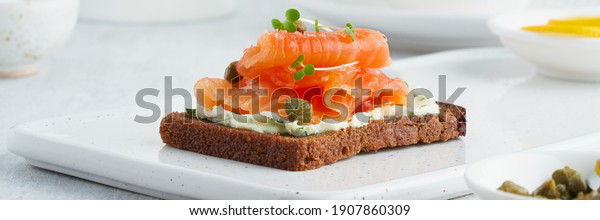

In [76]:
read_image_from_url(url)